In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from lhotse.recipes.ami import download, prepare_ami
from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.cut import CutSet
from lhotse.dataset.speech_recognition import SpeechRecognitionDataset
from lhotse.dataset.vad import VadDataset
from lhotse import LilcomFilesWriter

# Settings for paths

In [2]:
root_dir = Path('data')
output_dir = root_dir / 'ami_nb'

# Download the dataset

In [3]:
download(root_dir)

# Prepare audio and supervision manifests

In [4]:
ami_manifests = prepare_ami(root_dir, output_dir)

# Extract features

In [5]:
example = ami_manifests['dev']

with LilcomFilesWriter(f'{output_dir}/feats_example') as storage:
    feature_set_builder = FeatureSetBuilder(
        feature_extractor=Fbank(),
        storage=storage,
    )
    feature_set = feature_set_builder.process_and_store_recordings(
        recordings=example['audio'],
        num_jobs=1
    )
example['feats'] = feature_set

In [6]:
example['cuts'] = CutSet.from_manifests(supervisions=example['supervisions'], features=feature_set)

# Make pytorch Dataset for ASR task

In [7]:
asr_dataset = SpeechRecognitionDataset(example['cuts'].trim_to_supervisions())

# Illustation of an example

WELCOME EVERYBODY


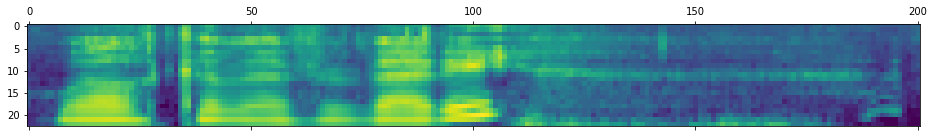

In [8]:
sample = asr_dataset[1]
print(sample['text'])
plt.matshow(sample['features'].transpose(0, 1).flip(0))

# Make pytorch Dataset for VAD task

In [9]:
vad_dataset = VadDataset(example['cuts'].cut_into_windows(10.0, keep_excessive_supervisions=True))

# Illustation of an example

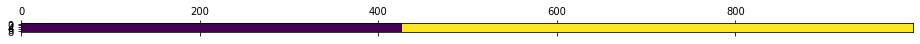

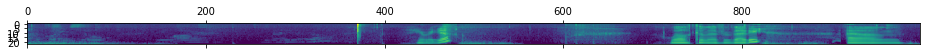

In [10]:
sample = vad_dataset[3]

label_height = 10
vad_label = torch.stack([sample['is_voice'] for i in range(label_height)]).reshape(label_height, 1000)
plt.matshow(vad_label)

plt.matshow(sample['features'].transpose(0, 1).flip(0))